## Can we get data near the [Coastal Endurance](http://oceanobservatories.org/array/coastal-endurance/) array?

This notebook uses a searches the csw NGDC catalog filtering the results with:
- (a) bounding box for the Coastal Endurance array;
- (b) time span of "today &plusmn; 5 days";
- (c) variable: temperature

This approach is very robust and was used before to analyze [coastal inundation](http://nbviewer.ipython.org/github/ocefpaf/inundation_notebook/blob/master/inundation_notebook.ipynb),
check the water temperature for the [Boston Light Swim](http://nbviewer.ipython.org/github/ocefpaf/boston_light_swim/blob/master/02-create_map.ipynb) event, and even evaluate numerical ocean models performance or [skill score](http://secoora.github.io/secoora/comparisons/timeSeries/).

![](http://oceanobservatories.org/wp-content/uploads/2011/04/Endurance-Array-Map_2013_04-17_ver_0-02.jpg)

### First step: create the filter

(a) Bounding box: everything inside the dashed lines from the map above.

In [1]:
bbox = [-127, 43, -123.75, 48]

(b) Time span: today &plusmn;5 days.

In [2]:
from datetime import datetime, timedelta

dt = 5

date = datetime.utcnow()  # Uncomment to use now.
start = date - timedelta(days=dt)
stop = date + timedelta(days=dt)

In [3]:
from owslib import fes


def fes_date_filter(start, stop):
    """
    Take datetime-like objects and returns a fes filter for date range
    (begin and end inclusive).
    NOTE: Truncates the minutes!!!
    
    """
    start = start.strftime('%Y-%m-%d %H:00')
    stop = stop.strftime('%Y-%m-%d %H:00')

    propertyname = 'apiso:TempExtent_begin'
    begin = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                            literal=stop)
    propertyname = 'apiso:TempExtent_end'
    end = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                             literal=start)
    return begin, end

In [4]:
begin, end = fes_date_filter(start, stop)

(c) Variable: `sea water temperature`.

(All names in `name_list` are [CF standard names](http://cfconventions.org/standard-names.html), but we can uses non-CF like 'Water Temperature' and that will return more datasets.)

In [5]:
sos_name = 'sea_water_temperature'

name_list = ['sea_water_temperature',
             'sea_surface_temperature',
             'sea_water_potential_temperature',
             'equivalent_potential_temperature',
             'sea_water_conservative_temperature',
             'pseudo_equivalent_potential_temperature']

Assemble the `fes` filter with `a`+`b`+`c`.

In [6]:
kw = dict(wildCard='*',
          escapeChar='\\',
          singleChar='?',
          propertyname='apiso:AnyText')

or_filt = fes.Or([fes.PropertyIsLike(literal=('*%s*' % val), **kw)
                  for val in name_list])

filter_list = [fes.And([begin, end, fes.BBox(bbox), or_filt])]

### Instantiate `csw` object using the NGDC catalog.

Now that we have the filter we can search the catalog.
(See [OWSLib](https://geopython.github.io/OWSLib) for more information on filtering (`fes`) and the [`CatalogueServiceWeb`](https://geopython.github.io/OWSLib/#csw).)

In [7]:
from owslib.csw import CatalogueServiceWeb

csw = CatalogueServiceWeb('http://www.ngdc.noaa.gov/geoportal/csw',
                          timeout=60)

csw.getrecords2(constraints=filter_list, maxrecords=1000, esn='full')

fmt = '{:*^64}'.format
print(fmt(' Catalog information '))
print("CSW version: {}".format(csw.version))
print("Number of datasets available: {}".format(len(csw.records.keys())))

********************* Catalog information **********************
CSW version: 2.0.2
Number of datasets available: 7


### What are the services available?

In [8]:
import pandas as pd

def service_urls(csw):
    df = []
    for key, rec in csw.records.items():
        df.append(pd.DataFrame(rec.references))

    df = pd.concat(df, ignore_index=True)
    df['scheme'] = [scheme.split(':')[-2] for scheme in df['scheme']]

    return df.set_index('scheme').sort_index().stack()

services = service_urls(csw)

print(fmt(' Services '))
for service in set(services.index.levels[0]):
    print(service)

*************************** Services ***************************
wcs
odp
wms
sos
download
distribution


### What do we have as `SOS` and `OPeNDAP`?

Why `SOS` and `OPeNDAP`?  Both services allow us to download and explore both the data and metadata using standard tools.
For SOS we have [pyoos](https://github.com/ioos/pyoos) (a Python library for collecting Met/Ocean observations), while for OPeNDAP we have many options:
[netCDF4-python](http://github.com/Unidata/netcdf4-python),
[iris](http://www.scitools.org.uk/iris),
[xray](https://github.com/xray/xray),
[siphon](https://github.com/Unidata/siphon)...

In [9]:
sos_urls = set(services['sos'].values.tolist())
print(fmt(' SOS '))
for url in sos_urls:
    print(url)

dap_urls = set(services['odp'].values.tolist())
print(fmt(' OPenDAP '))
for url in dap_urls:
    print(url)

***************************** SOS ******************************
http://sdf.ndbc.noaa.gov/sos/server.php?service=SOS&request=GetCapabilities&acceptVersions=1.0.0
http://data.nanoos.org/52nsos/sos/kvp?service=SOS&request=GetCapabilities&acceptVersions=1.0.0
*************************** OPenDAP ****************************
http://oos.soest.hawaii.edu/thredds/dodsC/hioos/satellite/dhw
http://thredds.axiomdatascience.com/thredds/dodsC/CA_DAS.nc
http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global
http://amb6400b.stccmop.org:8080/thredds/dodsC/model_data/forecast


Get the SOS data with pyoos `collectors`.

In [10]:
import copy
from io import BytesIO

from owslib.ows import ExceptionReport
from pandas import DataFrame, read_csv


def collector2table(collector, col='sea_water_temperature (C)'):
    c = copy.copy(collector)
    c.features = None
    try:
        response = c.raw(responseFormat="text/csv")
    except ExceptionReport:
        response = c.filter(end=c.start_time).raw(responseFormat="text/csv")

    df = read_csv(BytesIO(response.encode('utf-8')),
                  parse_dates=True)
    g = df.groupby('station_id')
    df = dict()
    for station in g.groups.keys():
        df.update({station: g.get_group(station).iloc[0]})
    df = DataFrame.from_dict(df).T
    
    names = []
    for sta in df.index:
        names.extend([offering.description for offering in c.server.offerings if sta == offering.name])
    df['name'] = names
    
    observations = []
    for k, row in df.iterrows():
        station_id = row['station_id'].split(':')[-1]
        c.features = [station_id]
        response = c.raw(responseFormat="text/csv")
        kw = dict(parse_dates=True, index_col='date_time')
        data = read_csv(BytesIO(response.encode('utf-8')), **kw).reset_index()
        data = data.drop_duplicates(subset='date_time').set_index('date_time')
        
        series = data[col]
        series._metadata = [dict(name=row['name'],
                                 station=row['station_id'],
                                 sensor=row['sensor_id'],
                                 lon=row['longitude (degree)'],
                                 lat=row['latitude (degree)'],
                                 depth=row['depth (m)'],)]

        observations.append(series)
    return observations

In [11]:
from pyoos.collectors.ndbc.ndbc_sos import NdbcSos
from pyoos.collectors.ioos.swe_sos import IoosSweSos
from pyoos.collectors.coops.coops_sos import CoopsSos

observations = []
for url in sos_urls:
    if 'co-ops' in url.lower():
        collector = CoopsSos()
    elif 'ndbc' in url.lower():
        collector = NdbcSos()
    else:
        collector = IoosSweSos(url)
    
    collector.set_bbox(bbox)
    collector.end_time = stop
    collector.start_time = start
    collector.variables = [sos_name]
    
    ofrs = collector.server.offerings
    title = collector.server.identification.title
    try:
        observations.extend(collector2table(collector))
        print('{}: {} offerings:'.format(title, len(ofrs)))
        print(fmt(' {} '.format(url)))
    except Exception as e:
        print('\nCannot collect:\n{}. {}'.format(url, e))

National Data Buoy Center SOS: 964 offerings:
 http://sdf.ndbc.noaa.gov/sos/server.php?service=SOS&request=GetCapabilities&acceptVersions=1.0.0 

Cannot collect:
http://data.nanoos.org/52nsos/sos/kvp?service=SOS&request=GetCapabilities&acceptVersions=1.0.0. 


### Let's take a look at the data we found.

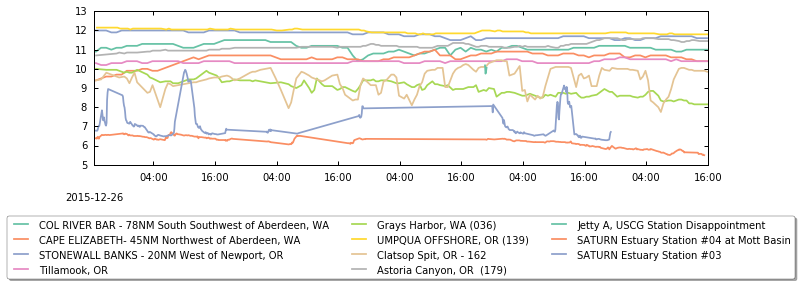

In [12]:
%matplotlib inline
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

def mpl_palette(cmap, n_colors=6):
    brewer_qual_pals = {"Accent": 8, "Dark2": 8, "Paired": 12,
                        "Pastel1": 9, "Pastel2": 8,
                        "Set1": 9, "Set2": 8, "Set3": 12}

    if cmap.name in brewer_qual_pals:
        bins = np.linspace(0, 1, brewer_qual_pals[cmap.name])[:n_colors]
    else:
        bins = np.linspace(0, 1, n_colors + 2)[1:-1]
    palette = list(map(tuple, cmap(bins)[:, :3]))

    pal_cycle = cycle(palette)
    palette = [next(pal_cycle) for _ in range(n_colors)]
    
    return palette

with mpl.style.context('seaborn-notebook'):
    fig, ax = plt.subplots(figsize=(11, 2.75))
    colors = mpl_palette(plt.cm.Set2, n_colors=len(observations))
    for k, series in enumerate(observations):
        station_name = series._metadata[0]['name']
        ax.plot(series.index, series, label=station_name, color=colors[k])
    leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
              ncol=3, fancybox=True, shadow=True)

hours = mpl.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(hours)

days = mpl.dates.DateFormatter('\n\n%Y-%m-%d')
ax.xaxis.set_minor_formatter(days)
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([mpl.dates.date2num(start)]))

fig.savefig('time_series.png', bbox_extra_artists=(leg,),
            bbox_inches='tight', dpi=150)

(The OPeNDAP endpoints found consists of numerical models and satellite data.
For the sake of brevity we won't download any data here, but we will show the model grids later on.)

### Interactive Map with the results

Now that we have all the pieces let's create an interactive map with all this information.

In [13]:
import folium
import numpy as np

location = np.array(bbox).reshape(2, 2).mean(axis=0).tolist()[::-1]
tiles = ('http://services.arcgisonline.com/arcgis/rest/'
         'services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}')

mapa = folium.Map(location=location, zoom_start=6, tiles=tiles, attr='ESRI')

Show the time-series as html (`bokeh`) plots.

In [14]:
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html

from folium.element import IFrame

def make_marker(series):
    width, height = 500, 250
    metadata = series._metadata[0]
    
    p = figure(x_axis_type="datetime",
               title=metadata['name'],
               width=width, height=height)
    p.line(series.index, series, line_width=2)
    html = file_html(p, CDN, metadata['station'].split(':')[-1])
    iframe = IFrame(html, width=width+40, height=height+80)
    
    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color='green', icon='stats')
    marker = folium.Marker(location=[metadata['lat'], metadata['lon']],
                           popup=popup,
                           icon=icon)
    return marker

for series in observations:
    make_marker(series).add_to(mapa)

Display the region bounding box and Endurance array lines.

In [15]:
oregon_line = [[44+35/60., -125], [44+35/60., -123.75]]
washington_line = [[47, -125], [47, -123.75]]
box = [[bbox[1], bbox[0]], [bbox[1], bbox[2]],
       [bbox[3], bbox[2]], [bbox[3], bbox[0]],
       [bbox[1], bbox[0]]]

folium.PolyLine(box, color='red').add_to(mapa)

folium.PolyLine(oregon_line,
                color='orange', popup='Oregon Line').add_to(mapa)
folium.PolyLine(washington_line,
                color='orange', popup='Washington Line').add_to(mapa)
mapa

Finally the numerical models grid outline.

In [16]:
import warnings

import iris
from folium import plugins
from netCDF4 import Dataset
from gridgeo import GridGeo

for url in dap_urls:
    # Drop global models and satellite data.
    if 'global' not in url and 'satellite' not in url:
        with Dataset(url) as nc:
            try:
                grid = GridGeo(nc)
            except ValueError:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    cube = iris.load_cube(url, 'potential temperature')
                    grid = GridGeo(cube)
            gj = folium.GeoJson(grid.outline.__geo_interface__)
            gj.add_children(folium.Popup(getattr(nc, 'summary', url)))
            mapa.add_children(gj)

In [17]:
mapa

### Summary

Using a simple filter we can search any CSW catalog and find both data/metadata.
We can then explore the endpoints found with tools like `pyoos` and `iris`.

Note that we hoped to find [CO-OPS](https://tidesandcurrents.noaa.gov/) data as well,
but due to an [unknown](https://github.com/ioos/registry/issues/90#issue-124377790) problem CO-OPS results are not showing-up.

We also did find data for Northwest Association of Networked Ocean Observing Systems (NANOOS), but the custom function `collector2table()` is not adapted to collect 52N data.  (It will be in a future version of this notebook.)